In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
from jax.scipy.optimize import minimize

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
def neg_log_likelihood(w, Phi, y):
    y = 2 * y.ravel() - 1
    an = jnp.einsum("nm,m->n", Phi, w)
    nll = jnp.log1p(jnp.exp(-y * an)).mean()
    return -nll


def E_base(w, Phi, y, alpha):
    """
    Base function containing the Energy of a logistic
    regression with. Energy log-joint
    """
    y = y.ravel() * 2 - 1
    an = Phi @ w
    log_likelihood_terms = jnp.log1p(jnp.exp(-y * an)).mean()
    log_prior_term = alpha * w @ w / 2

    return log_prior_term + log_likelihood_terms

## The data

In [4]:
np.random.seed(135)
# Creating data
N = 30
D = 2
mu1 = np.array([1, 5])
mu2 = np.array([-5, 1])
std1 = 1
std2 = 2.2
X1 = std1 * np.random.randn(N,2) +  mu1
X2 = std2 * np.random.randn(N,2) +  mu2
X = np.r_[X1, X2]
t = np.r_[np.ones(N), np.zeros(N)][:, None]

In [5]:
key = jax.random.PRNGKey(314)
key, key_sample = jax.random.split(key)

In [6]:
domain = 8
step = 0.1
Xgrid = np.mgrid[-domain:domain:step, -domain:domain:step]
ws = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])

In [7]:
Wgrid = Xgrid.copy()

In [8]:
nll_vmap = jax.vmap(neg_log_likelihood, (1, None, None))
nll_vmap = jax.vmap(nll_vmap, (2, None, None))

## Log-likelihood

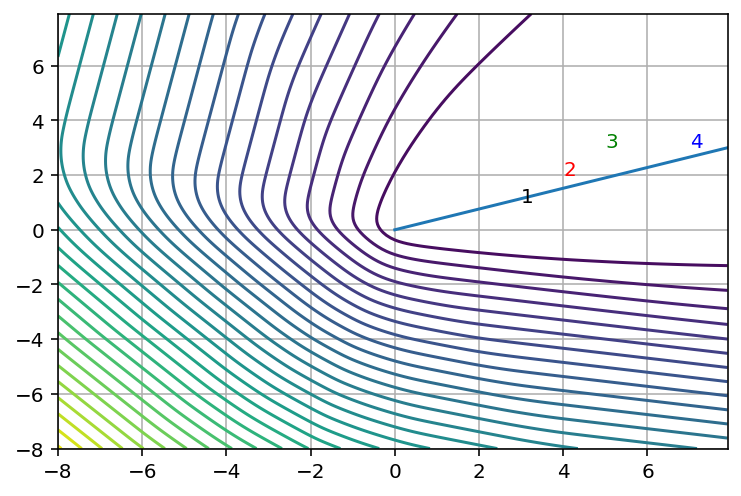

In [277]:
an = jnp.einsum("mij,nm->nij", Wgrid, X)
cst = jnp.einsum("mij,nm,nk->ij", Wgrid, X, t)

ll_grid = cst - jnp.log1p(jnp.exp(an)).sum(axis=0)
plt.contour(*Wgrid, -ll_grid, 30)

colors = ["black", "red", "green", "blue"]
for i, (wi, color) in enumerate(zip(ws, colors)):
    plt.annotate(str(i+1), xy=wi, color=color)

ix0, ix1 = jnp.where(ll_grid == ll_grid.max())
w_mle = Wgrid[:, ix0, ix1].ravel()

slope = w_mle[1] / w_mle[0]
plt.plot([0, 7.9], [0, 7.9*slope])
plt.grid()

## Log-posterior unnormalized 

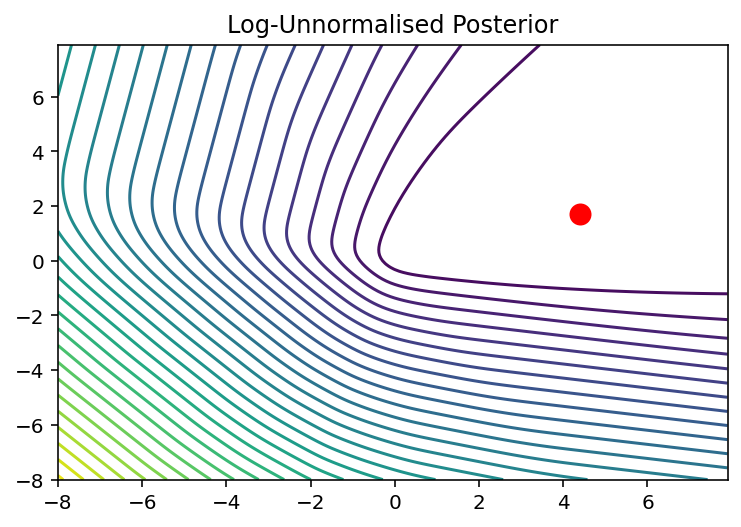

In [429]:
alpha = 100
mu0 = jnp.zeros(D)
Sigma0 = jnp.eye(D) * alpha

prior_logpdf = lambda w: multivariate_normal.logpdf(w, mu0, Sigma0)
prior_logpdf = jax.vmap(prior_logpdf, 1)
prior_logpdf = jax.vmap(prior_logpdf, 2)

prior_logpdf_grid = prior_logpdf(Wgrid)
log_joint_grid = prior_logpdf_grid + ll_grid

plt.contour(*Wgrid, -log_joint_grid, 30)
plt.title("Log-Unnormalised Posterior")

ix0, ix1 = jnp.where(log_joint_grid == log_joint_grid.max())
w_best = Wgrid[:, ix0, ix1].ravel()

plt.scatter(*w_best, c="red", s=100)

## Laplace approximation to posterior

In [510]:
def E_base(w, Phi, y, alpha):
    """
    Base function containing the Energy of a logistic
    regression with. Energy log-joint
    """
    y = y.ravel()
    an = Phi @ w
    log_an = jax.nn.log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * jnp.log1p(-jax.nn.sigmoid(an))
    log_prior_term = -alpha * w.T @ w / 2

    return log_prior_term + log_likelihood_term.sum()


In [511]:
an = jnp.einsum("mij,nm->nij", Wgrid, X)
cst = jnp.einsum("mij,nm,nk->ij", Wgrid, X, t)

ll_grid = cst - jnp.log1p(jnp.exp(an)).sum(axis=0)

In [523]:
alpha = 5.0

# init_noise = 3.0
# w0 = jax.random.multivariate_normal(key, jnp.zeros(D), jnp.eye(D) * init_noise)

w0 = jnp.zeros(D)

E = lambda w: -E_base(w, X, t, alpha) / len(t)
res = minimize(E, w0, method="BFGS")
w_laplace = res.x
# Estimated precision matrix
SN = jax.hessian(E)(w_laplace)

res.success

DeviceArray(True, dtype=bool)

In [524]:
w_laplace

DeviceArray([0.9883831 , 0.50823194], dtype=float32)

In [525]:
jnp.linalg.inv(SN)

DeviceArray([[3.3373225 , 0.52785915],
             [0.52785915, 1.4764539 ]], dtype=float32)

Text(0.5, 1.0, 'Laplace Approximation to Posterior')

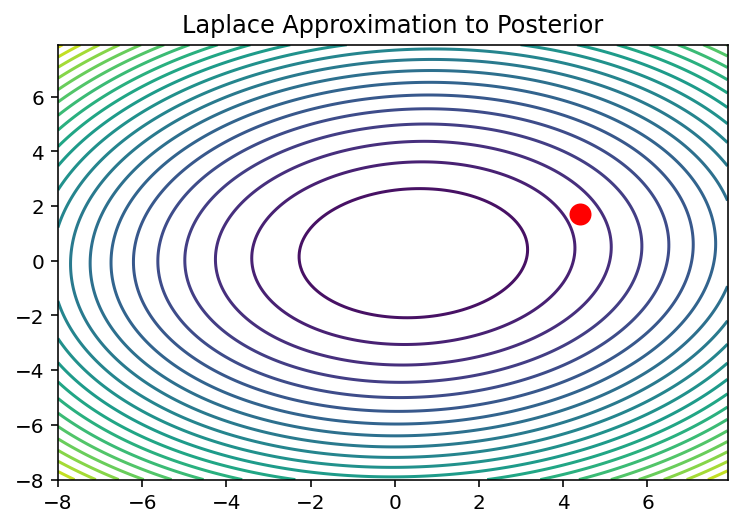

In [522]:
meanv = (Wgrid - w_laplace[:, None, None])
logpdf = jnp.einsum("mij,mn,nij->ij", meanv, SN, meanv)

plt.contour(*Wgrid, logpdf, 30)
plt.scatter(*w_best, c="red", s=100)
plt.title("Laplace Approximation to Posterior")

## Plotting the predictive distribution for logistic regression

Text(0.5, 1.0, 'p(y=1|x, wMAP)')

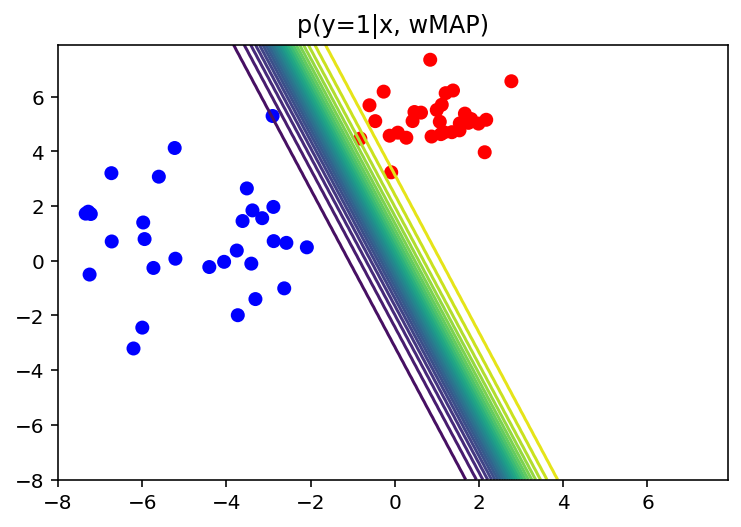

In [452]:
pred = jnp.einsum("m,mij->ij", w_laplace, Xgrid)
pred = jax.nn.sigmoid(pred)

plt.contour(*Xgrid, pred, 30)

colors = ["red" if ti==1 else "blue" for ti in t]
plt.scatter(*X.T, c=colors)
plt.title("p(y=1|x, wMAP)")

## Decision boundary for sampled $w$

```
SN = jnp.array([[2.74809243, 0.76832627],
                [0.76832627, 0.88442754]])                
```

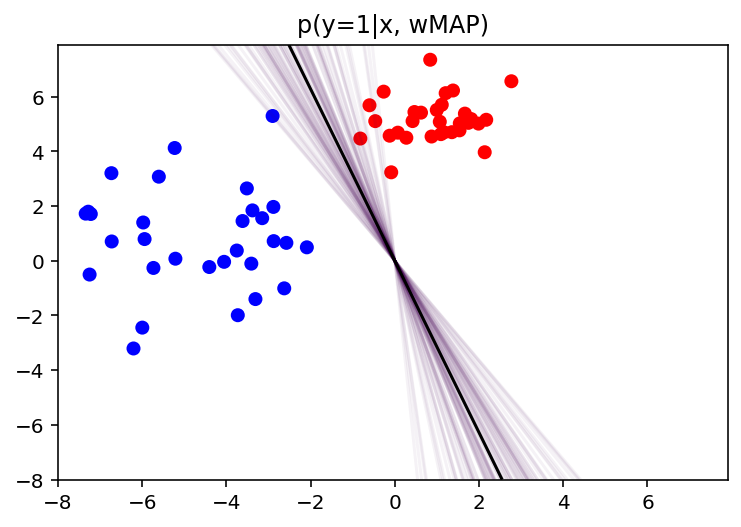

In [455]:
n_samples = 100

CN = jnp.linalg.inv(SN) # covariance matrix
w_laplace_samples = jax.random.multivariate_normal(key_sample, w_laplace, SN, shape=(n_samples,))

pred_samples = jnp.einsum("sm,mij->sij", w_laplace_samples, Xgrid)
pred_samples = jax.nn.sigmoid(pred_samples)

plt.scatter(*X.T, c=colors)
plt.title("p(y=1|x, wMAP)")

level = jnp.array([0.5])
for sample_grid in pred_samples:
    plt.contour(*Xgrid, sample_grid, level, alpha=0.05)
plt.contour(*Xgrid, pred_samples.mean(axis=0), level, colors="black")

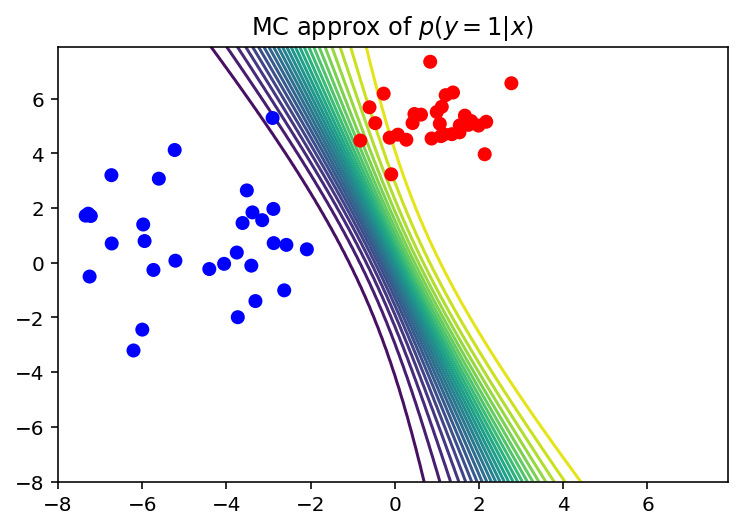

In [456]:
plt.scatter(*X.T, c=colors, zorder=2)
plt.contour(*Xgrid, pred_samples.mean(axis=0), 30, zorder=1)
plt.title("MC approx of $p(y=1|x)$");

## Probit approximation

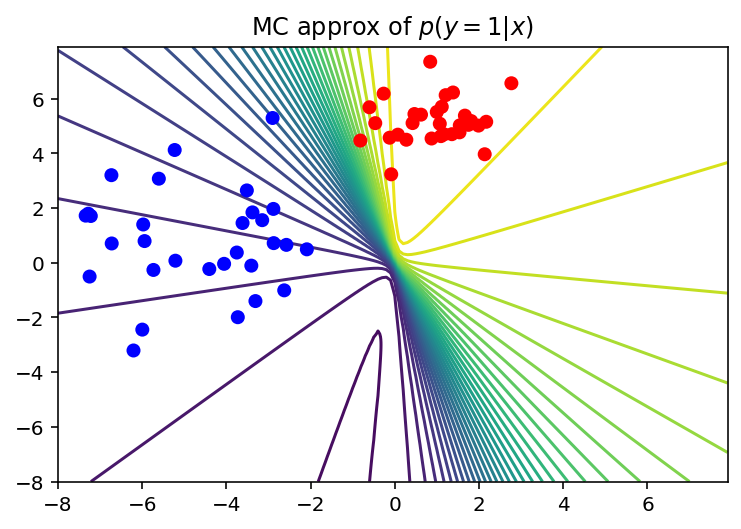

In [459]:
def k(z): return 1 / jnp.sqrt(1 + jnp.pi * z / 8)

m = jnp.einsum("mij,m->ij", Xgrid, w_laplace)
v = jnp.einsum("nij,nm,mij->ij", Xgrid, CN, Xgrid)

P_grid = jax.nn.sigmoid(k(v) * m)

plt.scatter(*X.T, c=colors, zorder=2)
plt.contour(*Xgrid, P_grid, 30, zorder=1)
plt.title("MC approx of $p(y=1|x)$");